### Course - CS-513 Knowledge Discovery and Data Mining
#### Problem Statement - Predict the prices of real estate in New York City using the dataset from Kaggle

In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('nyc-rolling-sales.csv')

# Dataset columns pre-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [3]:
# Clean dataset

# Drop unnamed serial name column which does not seem to give significant information
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check and drop columns where all cells are empty or -
df = df.applymap(lambda x: pd.NA if str(x).strip() in ['-', ''] else x)
df.dropna(axis=1, how='all', inplace=True)

# Dataset columns post-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            83810 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83810 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                19052 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

In [4]:
# View dataset statistics

print('(Rows, Columns):', df.shape)
df.head()


(Rows, Columns): (84548, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,<NA>,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,<NA>,10009,28,3,31,4616,18690,1900,2,C7,<NA>,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,<NA>,10009,16,1,17,2212,7803,1900,2,C7,<NA>,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,<NA>,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,<NA>,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [5]:
# Check data type of features
print('Data type of features', df.dtypes)

Data type of features BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


In [6]:
# Find categorical columns - columns with less than 10 unique values considered cateogrical for the purpose

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 10:
        categorical_columns.append(column)


print('Categorical columns:')
print(categorical_columns, '\n')

Categorical columns:
['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE'] 



In [7]:
# Filter out categorical features from 'categorical_columns' if they are truly useful in categorical sense
categorical_columns = ['BOROUGH', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert other feature types as and where required
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')


In [8]:
# Check if all features are appropriately set as per thier data types
print('Data type of features:')
df.dtypes

Data type of features:


BOROUGH                                 category
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE               category
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

In [9]:
# # Plot histogram for numerical data
# for column in df.columns:
#     # Check if the column is numeric
#     if pd.api.types.is_numeric_dtype(df[column]):
#         # Plot a histogram for numeric data
#         plt.figure(figsize=(8, 4))
#         sns.histplot(df[column], kde=True)
#         plt.title(f'Histogram of {column}')
#         plt.xlabel(column)
#         plt.ylabel('Frequency')
#         plt.show()

#     # Check if the column is categorical
#     elif pd.api.types.is_categorical_dtype(df[column]):
#         # Plot a countplot for categorical data
#         plt.figure(figsize=(8, 4))
#         sns.countplot(x=column, data=df)
#         plt.title(f'Countplot of {column}')
#         plt.xlabel(column)
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)
#         plt.show()

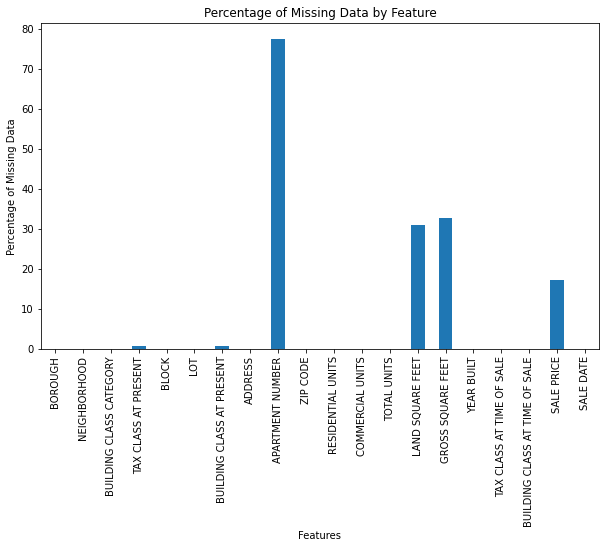

In [10]:
# Missing data - understand percentage of missing data


def show_missing_values(dataframe):
    # Calculate the percentage of missing data in each column
    missing_percentage = dataframe.isnull().mean() * 100

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind="bar")
    plt.ylabel("Percentage of Missing Data")
    plt.xlabel("Features")
    plt.title("Percentage of Missing Data by Feature")

    # Show the plot
    plt.show()

show_missing_values(df)

In [11]:
df.dtypes

BOROUGH                                 category
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE               category
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
dtype: object

## Treating Missing Values

In [12]:
# Treating missing values

# Remove rows with missing or 0 values in SALE PRICE which is target variable
df["SALE PRICE"] = df["SALE PRICE"].apply(lambda x: np.NAN if x <= 0 or "" else x)
df.dropna(subset=["SALE PRICE"], inplace=True)

# Check if SALE PRICE has any NA values
print(
    "Number of null or 0 values after cleanup from SALE PRICE:",
    df["SALE PRICE"].isna().sum(),
)


# Delete the APARTMENT NUMBER column
df.drop("APARTMENT NUMBER", axis=1, inplace=True)

# Remove rows with missing values in TAX CLASS AT PRESENT and BUILDING CLASS AT PRESENT
df.dropna(subset=["TAX CLASS AT PRESENT", "BUILDING CLASS AT PRESENT"], inplace=True)

df["SALE PRICE"].describe()

# change SALE PRICE to categorical variable
SALE_PRICE_LABELS = ["Low", "Medium", "High", "Very High"]
df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)

df.info()

df["SALE PRICE"].value_counts()

Number of null or 0 values after cleanup from SALE PRICE: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59166 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         59166 non-null  category      
 1   NEIGHBORHOOD                    59166 non-null  object        
 2   BUILDING CLASS CATEGORY         59166 non-null  category      
 3   TAX CLASS AT PRESENT            59166 non-null  category      
 4   BLOCK                           59166 non-null  int64         
 5   LOT                             59166 non-null  int64         
 6   BUILDING CLASS AT PRESENT       59166 non-null  object        
 7   ADDRESS                         59166 non-null  object        
 8   ZIP CODE                        59166 non-null  int64         
 9   RESIDENTIAL UNITS               59166 non-null  int64         
 10  COMMERCIAL

Medium       14931
Low          14803
Very High    14792
High         14640
Name: SALE PRICE, dtype: int64

In [13]:
# Check if LAND SQUARE FEET and GROSS SQUARE FEET are normally distributed

# plt.figure(figsize=(8, 4))
# sns.histplot(df['LAND SQUARE FEET'], kde=True)
# plt.title('Histogram of LAND SQUARE FEET')
# plt.xlabel('LAND SQUARE FEET')
# plt.ylabel('Frequency')
# plt.show()

# plt.figure(figsize=(8, 4))
# sns.histplot(df['GROSS SQUARE FEET'], kde=True)
# plt.title('Histogram of GROSS SQUARE FEET')
# plt.xlabel('GROSS SQUARE FEET')
# plt.ylabel('Frequency')
# plt.show()

In [14]:
# Create duplicate df for imputation
df_median_impute = df.copy()
df_mean_inpute = df.copy()
df_knn_impute = df.copy()
df_no_impute = df.copy()

# Impute the missing values in LAND SQUARE FEET and GROSS SQUARE FEET using different methods

# Impute using median
df_median_impute['LAND SQUARE FEET'] = df_median_impute['LAND SQUARE FEET'].fillna(df_median_impute['LAND SQUARE FEET'].median())
df_median_impute['GROSS SQUARE FEET'] = df_median_impute['GROSS SQUARE FEET'].fillna(df_median_impute['GROSS SQUARE FEET'].median())

# Impute using mean
df_mean_inpute['LAND SQUARE FEET'] = df_mean_inpute['LAND SQUARE FEET'].fillna(df_mean_inpute['LAND SQUARE FEET'].mean())
df_mean_inpute['GROSS SQUARE FEET'] = df_mean_inpute['GROSS SQUARE FEET'].fillna(df_mean_inpute['GROSS SQUARE FEET'].mean())

# Impute using KNN
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_knn_impute['LAND SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['LAND SQUARE FEET']])
df_knn_impute['GROSS SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['GROSS SQUARE FEET']])

# Delete rows with missing values fir df_no_impute
df_no_impute.dropna(inplace=True)

In [15]:
# Showing missing values after cleanup
# show_missing_values(df_median_impute)
# show_missing_values(df_mean_inpute)
# show_missing_values(df_knn_impute)

In [16]:
for col in [
    "BOROUGH",
    "NEIGHBORHOOD",
    "BUILDING CLASS CATEGORY",
    "TAX CLASS AT PRESENT",
    "BUILDING CLASS AT PRESENT",
    "BUILDING CLASS AT TIME OF SALE",
]:
    df_median_impute[col] = df_median_impute[col].astype("category")
    df_mean_inpute[col] = df_mean_inpute[col].astype("category")
    df_knn_impute[col] = df_knn_impute[col].astype("category")
    df_no_impute[col] = df_no_impute[col].astype("category")
    # label encoding
    df_median_impute[col] = df_median_impute[col].cat.codes
    df_mean_inpute[col] = df_mean_inpute[col].cat.codes
    df_knn_impute[col] = df_knn_impute[col].cat.codes
    df_no_impute[col] = df_no_impute[col].cat.codes

# convert sale date column values to year only
df_median_impute["SALE DATE"] = pd.DatetimeIndex(df_median_impute["SALE DATE"]).year
df_mean_inpute["SALE DATE"] = pd.DatetimeIndex(df_mean_inpute["SALE DATE"]).year
df_knn_impute["SALE DATE"] = pd.DatetimeIndex(df_knn_impute["SALE DATE"]).year
df_no_impute["SALE DATE"] = pd.DatetimeIndex(df_no_impute["SALE DATE"]).year

# drop address column
df_median_impute.drop("ADDRESS", axis=1, inplace=True)
df_mean_inpute.drop("ADDRESS", axis=1, inplace=True)
df_knn_impute.drop("ADDRESS", axis=1, inplace=True)
df_no_impute.drop("ADDRESS", axis=1, inplace=True)

In [17]:
# Model building
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def plot_confusion_matrix(cm, title):
    print(title)
    print(cm)
    # ax = plt.subplot()
    # sns.heatmap(cm, annot=True, fmt="g", ax=ax)
    # # annot=True to annotate cells, ftm='g' to disable scientific notation

    # # labels, title and ticks
    # ax.set_xlabel("Predicted labels")
    # ax.set_ylabel("True labels")
    # ax.set_title(title)
    # ax.xaxis.set_ticklabels(SALE_PRICE_LABELS)
    # ax.yaxis.set_ticklabels(SALE_PRICE_LABELS)


def get_predictions(model, X_train, X_test, y_train, y_test):
    # Fit the model to the training set
    model.fit(X_train, y_train)

    # Make predictions on the test set
    return model.predict(X_test)


def use_knn_model(dataframe):
    # Create a KNN model with default hyperparameters
    knn = KNeighborsClassifier()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    k_values = range(1, 21)
    accuracy_map = dict()

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        target_pred = get_predictions(knn, X_train, X_test, y_train, y_test)
        accuracy_map[k] = accuracy_score(y_test, target_pred) * 100

    # Plot the accuracy for different values of k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_map.values())
    plt.xticks(k_values)
    plt.xlabel("Value of k")
    plt.ylabel("Testing Accuracy")
    plt.title("Accuracy for different values of k")
    plt.show()

    # Get optimal k
    optimal_k = max(accuracy_map, key=accuracy_map.get)

    # Print the optimal k
    print("The optimal number of neighbors is {}".format(optimal_k))

    # Create a KNN model with optimal number of neighbors
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions using optimal k
    target_pred = get_predictions(knn_optimal, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for optimal k = " + str(optimal_k))

    print("Confusion Matrix for optimal k = " + str(optimal_k))

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_gaussian_nb_model(dataframe):
    # Create a GaussianNB model
    gaussian_nb = GaussianNB()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(gaussian_nb, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for GaussianNB")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_decision_tree_model(dataframe):
    from sklearn.tree import DecisionTreeClassifier

    # Create a DecisionTreeClassifier model
    decision_tree = DecisionTreeClassifier()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(decision_tree, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for DecisionTreeClassifier")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_cart_5_model(dataframe):
    from sklearn.tree import DecisionTreeClassifier

    # Create a DecisionTreeClassifier model
    decision_tree = DecisionTreeClassifier(max_depth=5)

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(decision_tree, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for CART-5.0")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_random_forest_model(dataframe):
    from sklearn.ensemble import RandomForestClassifier

    # Create a RandomForestClassifier model
    random_forest = RandomForestClassifier()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(random_forest, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for RandomForestClassifier")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_svm_model(dataframe):
    from sklearn.svm import SVC

    # Create a SVC model
    svc = SVC()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(svc, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for SVC")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_logistic_regression_model(dataframe):
    from sklearn.linear_model import LogisticRegression

    # Create a LogisticRegression model
    logistic_regression = LogisticRegression()

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Get predictions
    target_pred = get_predictions(logistic_regression, X_train, X_test, y_train, y_test)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for LogisticRegression")

    # Print the classification report
    print(classification_report(y_test, target_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, target_pred))


def use_xg_boost_model(dataframe):
    # Initialize the label encoder for the target variable
    label_encoder = LabelEncoder()

    # Copy the dataframe to avoid modifying the original data
    df = dataframe.copy()

    # Fit and transform the 'SALE PRICE' column
    df["SALE PRICE"] = label_encoder.fit_transform(df["SALE PRICE"])

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["category"]).columns

    # One-hot encode categorical columns
    one_hot_encoder = OneHotEncoder()
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Split the data into features and target
    X = df.drop("SALE PRICE", axis=1)
    y = df["SALE PRICE"]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Create a XGBClassifier model
    xgb_classifier = xgb.XGBClassifier()

    # Fit the model to the training set
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Generate and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix for XGBClassifier")

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Print the accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))


def use_sequential_dense_modal(dataframe):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.preprocessing import StandardScaler
    from tensorflow.keras.utils import to_categorical
    from sklearn.model_selection import train_test_split

    # Get the feature and target columns
    X = dataframe.drop("SALE PRICE", axis=1)
    y = dataframe["SALE PRICE"]

    # Convert the target column to categorical (one-hot encoding)
    y_encoded = to_categorical(y.cat.codes)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.3, random_state=42
    )

    # Get the number of input features
    n_features = X_train.shape[1]

    # Create a Sequential model
    model = Sequential()
    model.add(Dense(100, activation="relu", input_shape=(n_features,)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(4, activation="softmax"))  # Output layer for 4-class classification

    # Compile the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=10, validation_split=0.3)

    # Evaluating the Model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Accuracy: {accuracy}")

Dataframe:  Median Impute


KNN


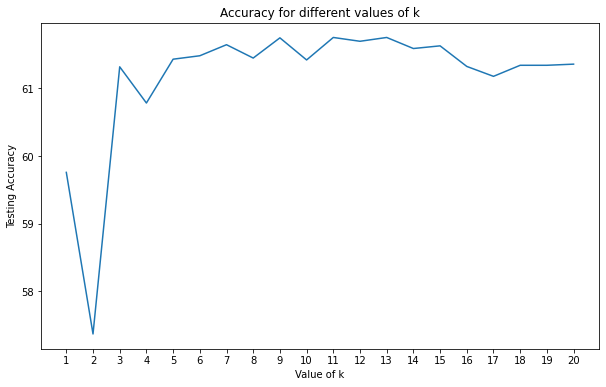

The optimal number of neighbors is 11
Confusion Matrix for optimal k = 11
[[2565  231  735  902]
 [ 433 2758  957  276]
 [ 998  838 2385  261]
 [ 919   78  161 3253]]
Confusion Matrix for optimal k = 11
              precision    recall  f1-score   support

        High       0.52      0.58      0.55      4433
         Low       0.71      0.62      0.66      4424
      Medium       0.56      0.53      0.55      4482
   Very High       0.69      0.74      0.71      4411

    accuracy                           0.62     17750
   macro avg       0.62      0.62      0.62     17750
weighted avg       0.62      0.62      0.62     17750

Accuracy: 0.6175211267605634


Gaussian NB
Confusion Matrix for GaussianNB
[[4346   10   63   14]
 [4213   61   42  108]
 [4423   19   21   19]
 [3805   71  265  270]]
              precision    recall  f1-score   support

        High       0.26      0.98      0.41      4433
         Low       0.38      0.01      0.03      4424
      Medium       0.05      0.

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression
[[ 815 1198  479 1941]
 [ 834 1485  887 1218]
 [ 723 1292 1049 1418]
 [ 282  674  119 3336]]
              precision    recall  f1-score   support

        High       0.31      0.18      0.23      4433
         Low       0.32      0.34      0.33      4424
      Medium       0.41      0.23      0.30      4482
   Very High       0.42      0.76      0.54      4411

    accuracy                           0.38     17750
   macro avg       0.37      0.38      0.35     17750
weighted avg       0.37      0.38      0.35     17750

Accuracy: 0.37661971830985913


XG Boost
Confusion Matrix for XGBClassifier
[[2595  113  770  955]
 [ 326 2873  971  254]
 [ 847  676 2706  253]
 [ 685   37   91 3598]]
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      4433
           1       0.78      0.65      0.71      4424
           2       0.60      0.60      0.60      4482
           3       0.71      0.82      0.76   

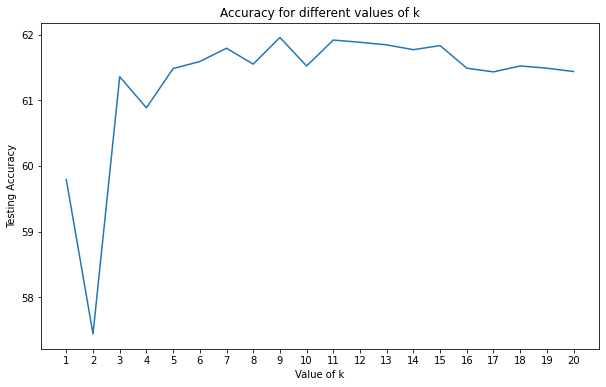

The optimal number of neighbors is 9
Confusion Matrix for optimal k = 9
[[2615  226  700  892]
 [ 427 2771  955  271]
 [1006  840 2385  251]
 [ 927  103  155 3226]]
Confusion Matrix for optimal k = 9
              precision    recall  f1-score   support

        High       0.53      0.59      0.56      4433
         Low       0.70      0.63      0.66      4424
      Medium       0.57      0.53      0.55      4482
   Very High       0.70      0.73      0.71      4411

    accuracy                           0.62     17750
   macro avg       0.62      0.62      0.62     17750
weighted avg       0.62      0.62      0.62     17750

Accuracy: 0.6195492957746479


Gaussian NB
Confusion Matrix for GaussianNB
[[4361   10   46   16]
 [4210   61   38  115]
 [4428   19   17   18]
 [3834   70  239  268]]
              precision    recall  f1-score   support

        High       0.26      0.98      0.41      4433
         Low       0.38      0.01      0.03      4424
      Medium       0.05      0.00 

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression
[[1017  390 1223 1803]
 [ 808  944 1349 1323]
 [ 821  367 1887 1407]
 [ 381  536  267 3227]]
              precision    recall  f1-score   support

        High       0.34      0.23      0.27      4433
         Low       0.42      0.21      0.28      4424
      Medium       0.40      0.42      0.41      4482
   Very High       0.42      0.73      0.53      4411

    accuracy                           0.40     17750
   macro avg       0.39      0.40      0.37     17750
weighted avg       0.39      0.40      0.37     17750

Accuracy: 0.39859154929577467


XG Boost
Confusion Matrix for XGBClassifier
[[2589  102  782  960]
 [ 318 2872  984  250]
 [ 822  666 2730  264]
 [ 695   36   95 3585]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      4433
           1       0.78      0.65      0.71      4424
           2       0.59      0.61      0.60      4482
           3       0.71      0.81      0.76   

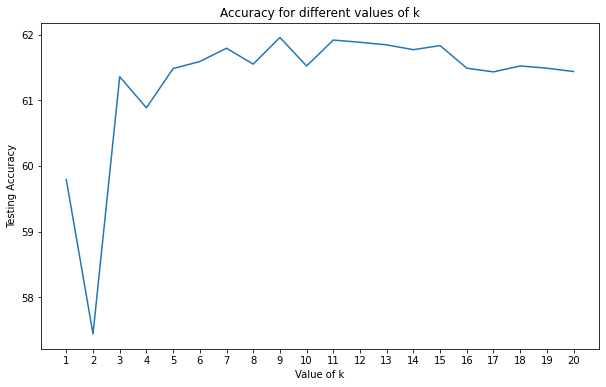

The optimal number of neighbors is 9
Confusion Matrix for optimal k = 9
[[2615  226  700  892]
 [ 427 2771  955  271]
 [1006  840 2385  251]
 [ 927  103  155 3226]]
Confusion Matrix for optimal k = 9
              precision    recall  f1-score   support

        High       0.53      0.59      0.56      4433
         Low       0.70      0.63      0.66      4424
      Medium       0.57      0.53      0.55      4482
   Very High       0.70      0.73      0.71      4411

    accuracy                           0.62     17750
   macro avg       0.62      0.62      0.62     17750
weighted avg       0.62      0.62      0.62     17750

Accuracy: 0.6195492957746479


Gaussian NB
Confusion Matrix for GaussianNB
[[4361   10   46   16]
 [4210   61   38  115]
 [4428   19   17   18]
 [3834   70  239  268]]
              precision    recall  f1-score   support

        High       0.26      0.98      0.41      4433
         Low       0.38      0.01      0.03      4424
      Medium       0.05      0.00 

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression
[[1017  390 1223 1803]
 [ 808  944 1349 1323]
 [ 821  367 1887 1407]
 [ 381  536  267 3227]]
              precision    recall  f1-score   support

        High       0.34      0.23      0.27      4433
         Low       0.42      0.21      0.28      4424
      Medium       0.40      0.42      0.41      4482
   Very High       0.42      0.73      0.53      4411

    accuracy                           0.40     17750
   macro avg       0.39      0.40      0.37     17750
weighted avg       0.39      0.40      0.37     17750

Accuracy: 0.39859154929577467


XG Boost
Confusion Matrix for XGBClassifier
[[2589  102  782  960]
 [ 318 2872  984  250]
 [ 822  666 2730  264]
 [ 695   36   95 3585]]
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      4433
           1       0.78      0.65      0.71      4424
           2       0.59      0.61      0.60      4482
           3       0.71      0.81      0.76   

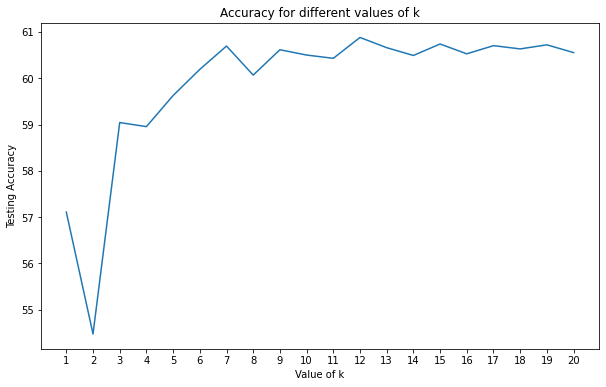

The optimal number of neighbors is 12
Confusion Matrix for optimal k = 12
[[1969  121  550  458]
 [ 381 1305  774  169]
 [ 691  547 1916  108]
 [ 536   44   51 1704]]
Confusion Matrix for optimal k = 12
              precision    recall  f1-score   support

        High       0.55      0.64      0.59      3098
         Low       0.65      0.50      0.56      2629
      Medium       0.58      0.59      0.58      3262
   Very High       0.70      0.73      0.71      2335

    accuracy                           0.61     11324
   macro avg       0.62      0.61      0.61     11324
weighted avg       0.61      0.61      0.61     11324

Accuracy: 0.6087954786294596


Gaussian NB
Confusion Matrix for GaussianNB
[[ 532   45 2498   23]
 [ 218  130 2126  155]
 [ 306   22 2910   24]
 [ 629   93 1226  387]]
              precision    recall  f1-score   support

        High       0.32      0.17      0.22      3098
         Low       0.45      0.05      0.09      2629
      Medium       0.33      0.

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression
[[1321   70 1112  595]
 [ 387  170 1778  294]
 [ 559   51 2357  295]
 [ 778  197  205 1155]]
              precision    recall  f1-score   support

        High       0.43      0.43      0.43      3098
         Low       0.35      0.06      0.11      2629
      Medium       0.43      0.72      0.54      3262
   Very High       0.49      0.49      0.49      2335

    accuracy                           0.44     11324
   macro avg       0.43      0.43      0.39     11324
weighted avg       0.43      0.44      0.40     11324

Accuracy: 0.4418050158954433


XG Boost
Confusion Matrix for XGBClassifier
[[2047   73  533  445]
 [ 290 1363  827  149]
 [ 564  430 2166  102]
 [ 408   24   33 1870]]
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      3098
           1       0.72      0.52      0.60      2629
           2       0.61      0.66      0.64      3262
           3       0.73      0.80      0.76    

In [18]:
df_map = {
    "Median Impute": df_median_impute,
    "Mean Impute": df_mean_inpute,
    "KNN Impute": df_knn_impute,
    "No Impute": df_no_impute,
}

for df_key in df_map.keys():
    # Get df_name from key
    print("Dataframe: ", df_key)
    print("\n")

    df_item = df_map[df_key]

    print("KNN")
    use_knn_model(df_item)
    print("\n")

    print("Gaussian NB")
    use_gaussian_nb_model(df_item)
    print("\n")

    print("Decision Tree")
    use_decision_tree_model(df_item)
    print("\n")

    print("CART 5")
    use_cart_5_model(df_item)
    print("\n")

    print("Random Forest")
    use_random_forest_model(df_item)
    print("\n")

    print("SVM")
    use_svm_model(df_item)
    print("\n")


    print("Logistic Regression")
    use_logistic_regression_model(df_item)
    print("\n")

    print("XG Boost")
    use_xg_boost_model(df_item)
    print("\n")

    print("Sequential Dense Model")
    use_sequential_dense_modal(df_item)
    print("\n\n")

In [19]:
use_sequential_dense_modal(df_median_impute)

Epoch 1/10
906/906 [==============================] - 1s 803us/step - loss: 1.1114 - accuracy: 0.5225 - val_loss: 1.0392 - val_accuracy: 0.5442
Epoch 2/10
906/906 [==============================] - 1s 746us/step - loss: 1.0117 - accuracy: 0.5602 - val_loss: 1.0128 - val_accuracy: 0.5607
Epoch 3/10
906/906 [==============================] - 1s 742us/step - loss: 0.9785 - accuracy: 0.5731 - val_loss: 0.9984 - val_accuracy: 0.5727
Epoch 4/10
906/906 [==============================] - 1s 742us/step - loss: 0.9577 - accuracy: 0.5860 - val_loss: 0.9648 - val_accuracy: 0.5894
Epoch 5/10
906/906 [==============================] - 1s 742us/step - loss: 0.9427 - accuracy: 0.5907 - val_loss: 0.9596 - val_accuracy: 0.5809
Epoch 6/10
906/906 [==============================] - 1s 853us/step - loss: 0.9314 - accuracy: 0.5963 - val_loss: 0.9426 - val_accuracy: 0.5915
Epoch 7/10
906/906 [==============================] - 1s 923us/step - loss: 0.9266 - accuracy: 0.6008 - val_loss: 0.9407 - val_accuracy: